In [1]:
import xarray as xr
import os
import xcdat
import numpy as np
from eofs.xarray import Eof
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def eof_calc_alt(data,lats):

    coslat = np.cos(np.deg2rad(lats.values)).clip(0., 1.)
    wgts = np.sqrt(coslat)[np.newaxis, :] # position ':' at latitude

    solver = Eof(data, weights=wgts, center=True)

    eofs = solver.eofsAsCovariance(neofs=1)
    pc1 = solver.pcs(npcs=1) #, pcscaling=1)  # <---- removed because pcscaling=1 is unit variance : default is un-scaled

    variance_fractions = solver.varianceFraction(neigs=3)

    return eofs, pc1, variance_fractions, solver

# Compare vertically averaged zonal wind to real NAO
(Same method as SAM index)

## Step 1: Import daily data and calculate anomalies

In [4]:
path = '/home/links/ct715/data_storage/reanalysis/jra55_daily'
data_file = os.path.join(path, 'jra55_uvtw.nc')
ds = xr.open_mfdataset(data_file, chunks={'time': 30})
ds = ds.sel(time=slice('1979-01', '2010-12-31'))
# ds = ds.sel(time=slice('1958-03', '2016-11'))
ds = ds.bounds.add_missing_bounds(axes='T')

var_anoms = ds.temporal.departures(data_var='u', freq='day', weighted=True)['u'].mean('lon')

# Select the desired latitudes and pressure levels.
var_anoms_hem = var_anoms.sel(lat=slice(0,-90)).sel(level=500).compute()
var_anoms_hem

<xarray.DataArray 'u' (time: 11680, lat: 37)> Size: 3MB
array([[ 8.91102089e-01,  1.13342353e+00,  1.22586466e+00, ...,
        -4.40869821e-01,  1.07211032e+00,  2.78724564e-04],
       [ 2.05602099e+00,  1.45638110e+00,  8.68248026e-01, ...,
        -8.76184702e-02,  2.12533149e+00, -6.84062640e-04],
       [ 2.44057957e+00,  1.79187759e+00,  1.18994718e+00, ...,
         1.88531054e+00,  1.50524971e+00,  1.90575918e-04],
       ...,
       [ 4.73386950e-01,  3.59168132e-01,  2.53243314e-01, ...,
         6.19783187e+00,  3.03449670e+00, -5.71383370e-04],
       [ 4.59599257e-01,  4.30212524e-01,  7.96279351e-01, ...,
         5.49581514e+00,  4.50806117e+00, -7.77059131e-04],
       [ 3.89896512e-01,  3.53073663e-01,  1.01426921e+00, ...,
         4.93186327e+00,  3.74122335e+00, -3.30064032e-04]])
Coordinates:
  * time     (time) datetime64[ns] 93kB 1979-01-01T09:00:00 ... 2010-12-31T09...
  * lat      (lat) float64 296B 0.0 -2.5 -5.0 -7.5 ... -82.5 -85.0 -87.5 -90.0
    level    float64 8B 500.0

## Step 2: calculate EOFs

In [5]:
eofs_day, pc1_day, variance_fractions_day, solver_day = eof_calc_alt(var_anoms_hem, var_anoms_hem.lat)

# Create an xarray Dataset and save the computed outputs.
eofs_ds = xr.Dataset(coords=eofs_day.coords)
eofs_ds['eofs'] = eofs_day
eofs_ds['pc1'] = pc1_day
eofs_ds['variance_fractions'] = variance_fractions_day

eofs_ds.to_netcdf('./data/jra55/jra55_daily_u500_eofs_sh.nc')

In [6]:
eofs_ds = xr.open_dataset('./data/jra55/jra55_daily_u500_eofs_sh.nc')
pc1 = -eofs_ds['pc1'].sel(mode=0)
pc1 = pc1.sel(time=slice('1979-01', '2010-12-31'))
pc1

<xarray.DataArray 'pc1' (time: 11680)> Size: 93kB
array([-5.24294597, -2.05332001,  2.16838934, ..., -1.16624417,
        1.3026765 ,  3.39758006])
Coordinates:
    mode     int64 8B 0
  * time     (time) datetime64[ns] 93kB 1979-01-01T09:00:00 ... 2010-12-31T09...

## Step 3: calculate correlation

In [7]:
AAO_path = '/home/links/ct715/data_storage/indices/SAM'
csv_file = 'norm.daily.aao.cdas.z700.19790101_current.csv'
AAO_data = os.path.join(AAO_path, csv_file)
df = pd.read_csv(AAO_data)

# Suppose your DataFrame is named df and has columns: year, month, day, aao_index_cdas
# Create a datetime column
df['date'] = pd.to_datetime(df[['year','month','day']])
# df = df.loc['1978-03':'2011-02']
df = df[(df['date'] >= '1979-01-01') & (df['date'] <= '2010-12-31')]
# df = df[(df['date'] >= '1958-03-01') & (df['date'] <= '2016-11-31')]

# Sort by date just to be sure it's in ascending order
df = df.sort_values('date').reset_index(drop=True)
df

,year,month,day,aao_index_cdas,date
0,1979,1,1,-1.556303,1979-01-01
1,1979,1,2,-0.888227,1979-01-02
2,1979,1,3,0.255268,1979-01-03
3,1979,1,4,0.861966,1979-01-04
4,1979,1,5,0.890381,1979-01-05
...,...,...,...,...,...
11683,2010,12,27,-0.137961,2010-12-27
11684,2010,12,28,-0.032587,2010-12-28
11685,2010,12,29,0.506834,2010-12-29
11686,2010,12,30,0.789990,2010-12-30


In [8]:
# Create a mask that finds leap-day rows
leap_days = (df['date'].dt.month == 2) & (df['date'].dt.day == 29)
# Then invert that mask to keep everything else
df = df[~leap_days].copy()

# 1) Make sure df has a DateTimeIndex
df = df.set_index('date')  # Make 'date' the index
df.index = pd.to_datetime(df.index)  # Ensure it's a DateTimeIndex

# 2) Convert your pandas Series to an xarray DataArray
#    Let's say your PC1 is in df['pc1']:
ref_aao = df['aao_index_cdas'].to_xarray()  # pc1_da will be a 1D DataArray with dimension 'date'

# 3) Ensure your existing xarray DataArray 'da' has a matching time dimension
#    Optionally rename dimensions so both arrays share the same dimension name:
#    (some data might have 'time', the other might have 'date'; unify them)
ref_aao = ref_aao.rename({'date': 'time'})  
# Now pc1_da and da both have dimension 'time' (assuming 'da' was also 'time').
ref_aao['time'] = ref_aao['time'].dt.strftime('%Y-%m-%d')

aao = pc1 #.sel(time=slice('1958-03', '2016-11')) #.values
aao['time'] = aao['time'].dt.strftime('%Y-%m-%d')

# calculate correlation after ensuring both DataArrays have the same time dimension
ref_aao_aligned, fy_aligned = xr.align(ref_aao, aao, join='inner')
r = xr.corr(ref_aao_aligned, fy_aligned, dim='time')
print("Correlation:", r.values)

Correlation: 0.7676055931045911


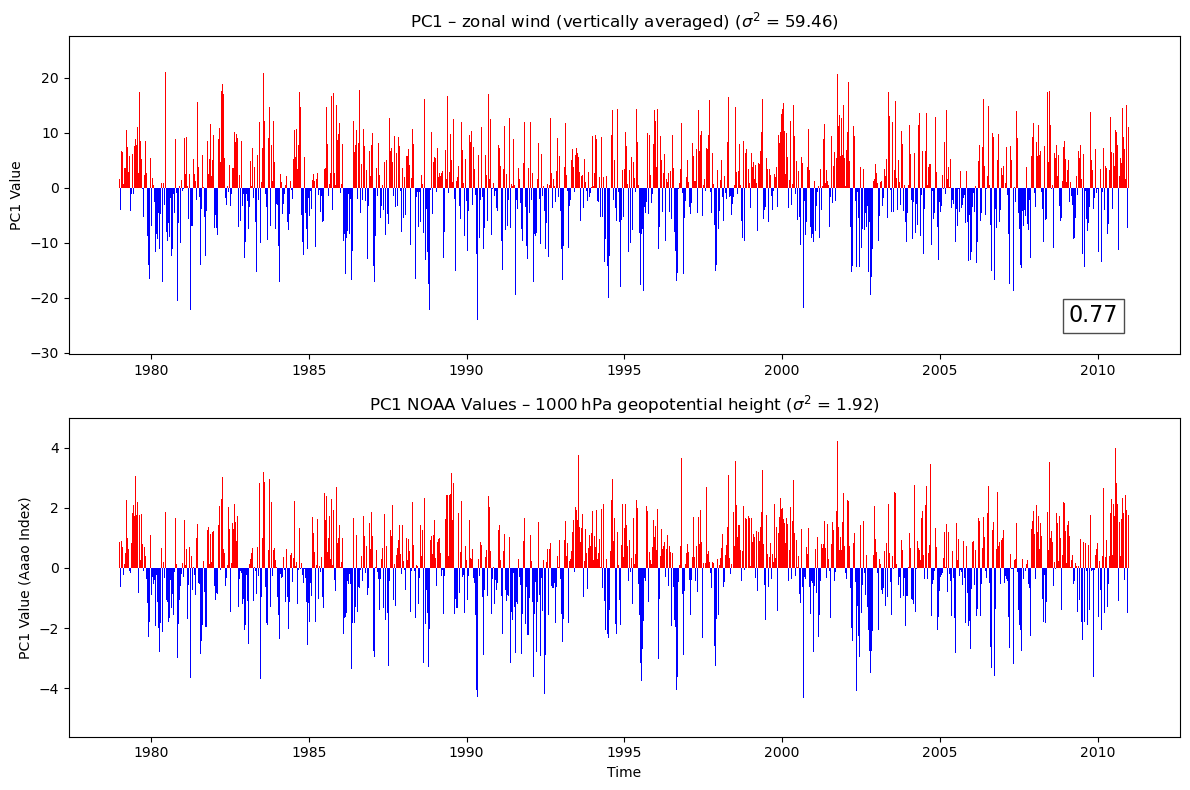

In [9]:
# ── Convert the coordinate once ───────────────────────────────
aao_times = pd.to_datetime(aao.time)        # -> dtype='datetime64[ns]'
aao_vals  = aao.values                      # y‑data

# A 1‑day bar looks good for daily data
bar_width = 1                               # units = “days” on a date axis

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 8))

# ---- panel 1 -------------------------------------------------
colors = ['red' if v >= 0 else 'blue' for v in aao_vals]

ax1.bar(aao_times, aao_vals, color=colors, width=bar_width)
ax1.set_ylabel('PC1 Value')
ax1.set_title(f'PC1 – zonal wind (vertically averaged) ($\\sigma^2$ = {aao.var():.2f})')

ax1.text(0.9, 0.1,
         f'{r.values.round(2)}',
         transform=ax1.transAxes,
         fontsize=16,
         bbox=dict(facecolor='white', alpha=0.7))

# ---- panel 2 -------------------------------------------------
# Make sure the “time” column is already datetime64[ns]
pc1_times = pd.to_datetime(ref_aao['time'])
pc1_vals  = ref_aao.values
colors_df = ['red' if v >= 0 else 'blue' for v in pc1_vals]

if len(pc1_times) > 1:
    bar_width_df = (pc1_times[1] - pc1_times[0]).days
else:
    bar_width_df = 1

ax2.bar(pc1_times, pc1_vals, color=colors_df, width=bar_width_df)
ax2.set_xlabel('Time')
ax2.set_ylabel('PC1 Value (Aaao Index)')
ax2.set_title(f'PC1 NOAA Values – 1000 hPa geopotential height ($\\sigma^2$ = {ref_aao.var():.2f})')

# Optional: prettier date formatting
for ax in (ax1, ax2):
    ax.xaxis.set_major_locator(mdates.YearLocator(5))   # tick every 5 years
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x')

plt.tight_layout()
plt.show()
